In [38]:
## Loading in Dataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt



data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

df['target'] = data.target

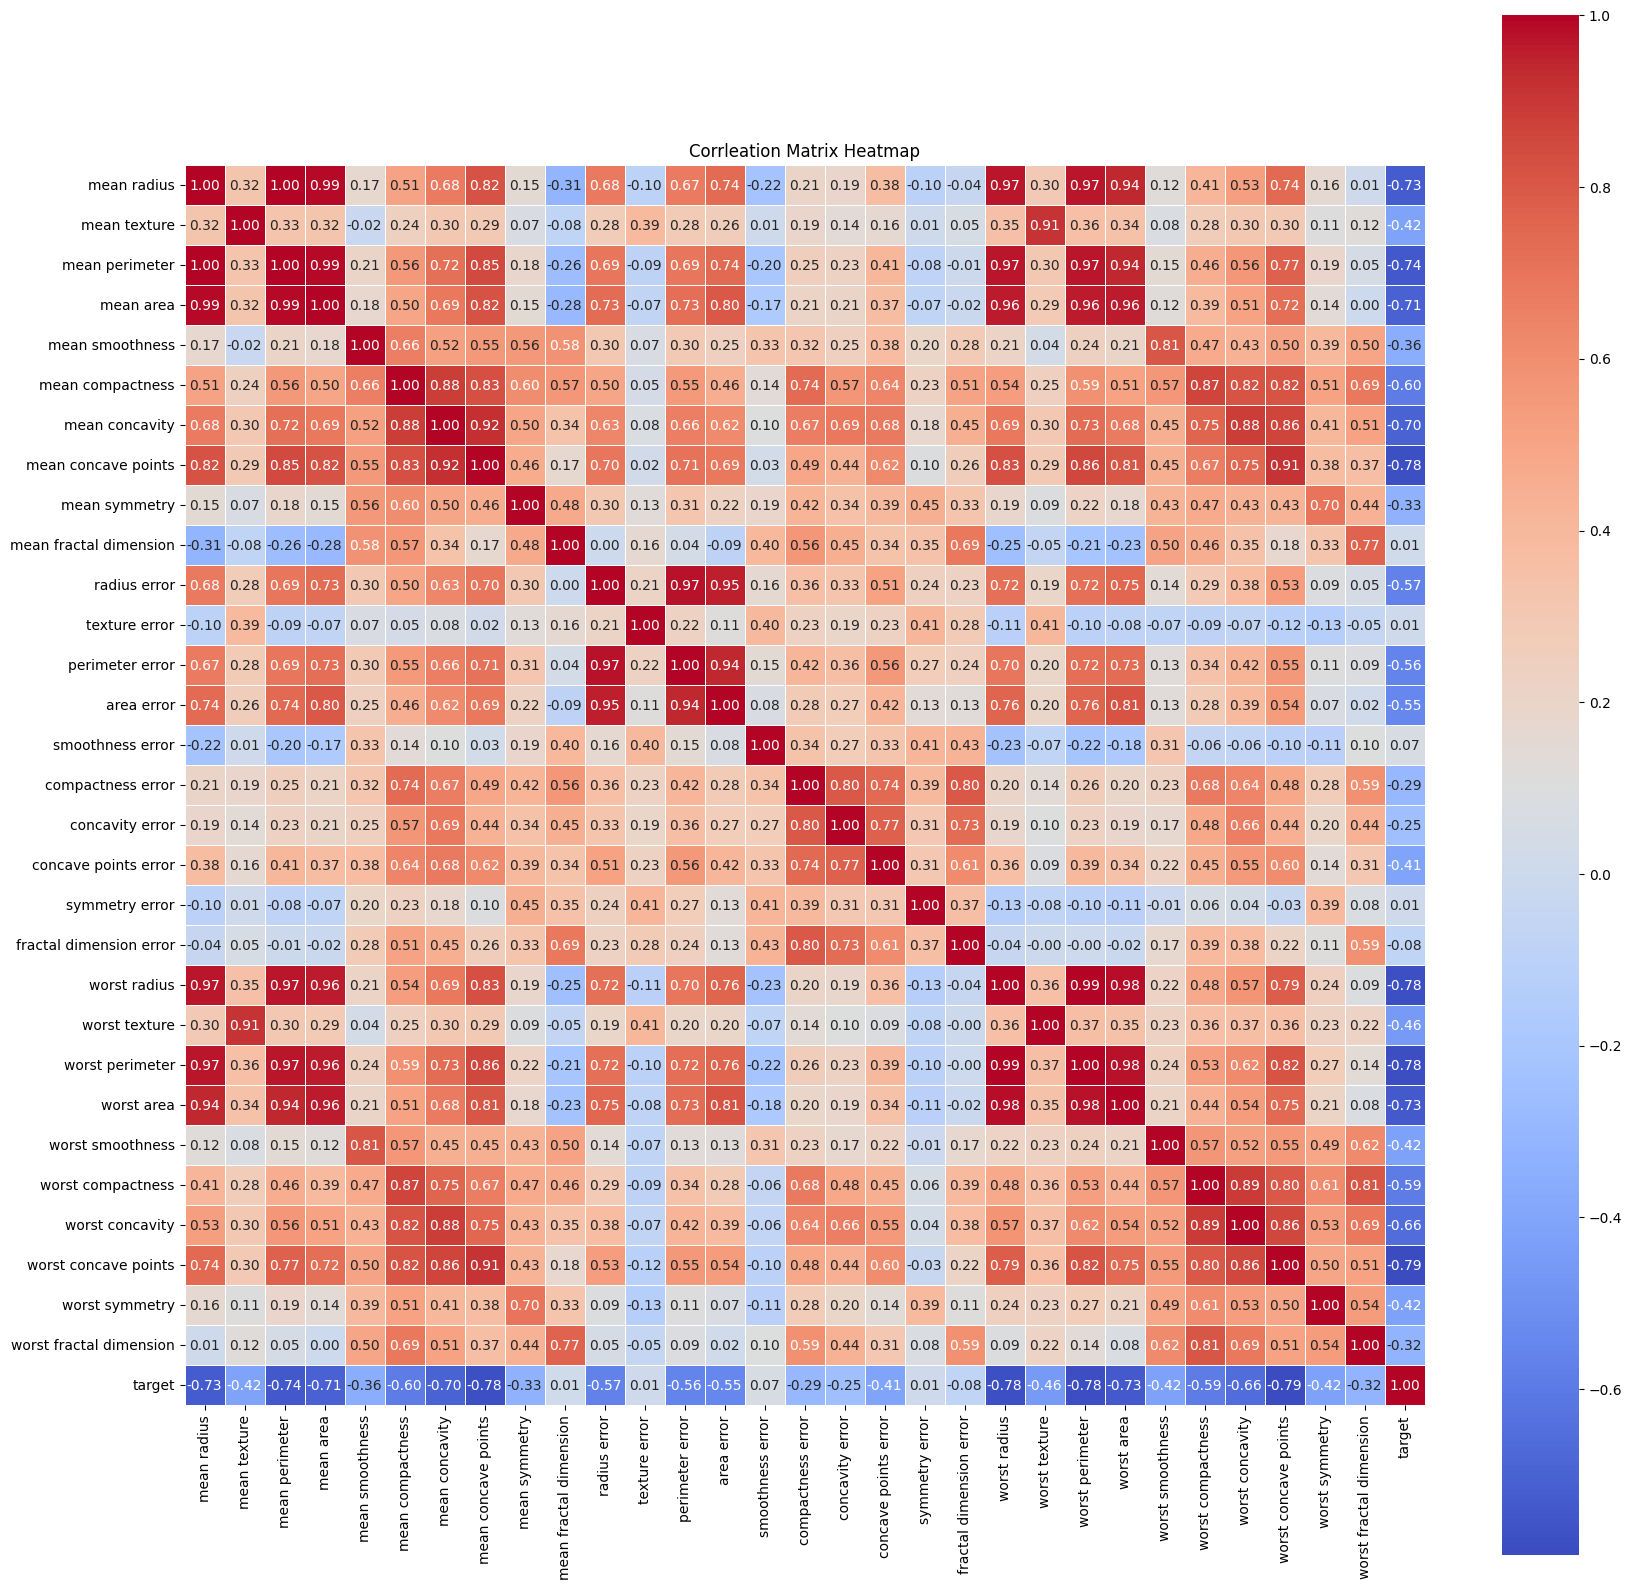

In [39]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("Corrleation Matrix Heatmap")
plt.show()

In [56]:
## Splitting Data into Training - Test- Validation

X = df.drop(columns='target')
Y = df['target']
print(df.columns)

X2 = df.drop(columns=['target','mean fractal dimension', 'texture error', 'smoothness error', 'symmetry error', 'fractal dimension error'])

## Splitting data set into trainicng, testing, and validating set
x_train, x_temp , y_train, y_temp = train_test_split(X,Y, test_size=0.4, random_state=42)
x_test, x_val , y_test, y_val = train_test_split(x_temp,y_temp, test_size=0.5, random_state=42)



Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')


In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}


rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.040987855392156866


In [58]:
forest_model = RandomForestClassifier(n_estimators= 100, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, random_state=193)
forest_model.fit(x_train, y_train)




RandomForestClassifier(random_state=193)

In [65]:
y_pred = forest_model.predict(x_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9825
Precision: 0.9861
Recall:    0.9861
F1 Score:  0.9861


In [9]:
# Own Implementation

import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        """
        Initialize the DecisionTree.
        min_samples_split: Minimum samples required to split a node.
        max_depth: Maximum depth of the tree.
        n_features: Number of features to consider when looking for the best split.
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        """
        Build the decision tree from the training set (X, y).
        """
        # If n_features is not set, use all features; otherwise, use the minimum of set value and total features
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        """
        Recursively grow the decision tree.
        """
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))  # Number of unique classes in current node

        # Stopping criteria: max depth, pure node, or not enough samples to split
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Randomly select features to consider for split
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best feature and threshold to split on
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # Split the data
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        """
        Find the best feature and threshold to split on based on information gain.
        """
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)  # All unique values for this feature

            for thr in thresholds:
                # Calculate information gain for this split
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        """
        Calculate information gain from splitting on a threshold.
        """
        parent_entropy = self._entropy(y)

        # Split the data
        left_idxs, right_idxs = self._split(X_column, threshold)

        # If no split, return 0 gain
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # Weighted average entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # Information gain is reduction in entropy
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        """
        Split data indices into left and right based on threshold.
        """
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        """
        Calculate entropy of label array y.
        """
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        """
        Return the most common label in y.
        """
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        """
        Predict class labels for samples in X.
        """
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        """
        Traverse the tree recursively to make a prediction for a single sample.
        """
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [19]:

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        """
        Initialize the RandomForest.
        n_trees: Number of trees in the forest.
        max_depth: Maximum depth of each tree.
        min_samples_split: Minimum samples required to split a node.
        n_feature: Number of features to consider at each split.
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_feature
        self.trees = []

    def fit(self, X, y):
        """
        Build a forest of decision trees from the training set (X, y).
        """
        self.trees = []
        for _ in range(self.n_trees):
            # Create a new decision tree
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                n_features=self.n_features)
            # Bootstrap sample (random sample with replacement)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        """
        Generate a bootstrap sample from X and y.
        """
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        """
        Return the most common label in y.
        """
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        """
        Predict class labels for samples in X by aggregating predictions from all trees.
        """
        # Get predictions from each tree
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Transpose to shape (n_samples, n_trees)
        tree_preds = np.swapaxes(predictions, 0, 1)
        # Majority vote for each sample
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

Accuracy: 0.9647058823529412
